# A COVID-19 Dataset analysis and processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile

### The Dataset

The data (sourced [here](https://github.com/nshomron/covidpred)) is from the paper [Machine learning-based prediction of Covid-19 diagnosis based on symptoms](https://www.nature.com/articles/s41746-020-00372-6.pdf)

# Exploratory Data Analysis

### Part 1: Load Data, Data Analysis and Processing

In [2]:
zf = ZipFile("data/corona_tested_individuals_ver_00220.english.zip")

df = pd.read_csv(zf.open("corona_tested_individuals_ver_00220.english.csv"),low_memory=False)

In [3]:
# # Install pandas profiling if needed
# !pip install pandas-profiling==2.7.1

In [4]:
df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2022-01-30,0,0,0,0,0,positive,No,female,Other
1,2022-01-30,0,0,0,0,0,positive,No,female,Other
2,2022-01-30,0,0,0,0,0,positive,No,male,Other
3,2022-01-30,0,0,0,0,0,positive,No,female,Other
4,2022-01-30,0,0,0,0,0,positive,No,female,Other


In [5]:
df["corona_result"] = df["corona_result"].map({"negative": 0, "positive": 1, "other": 0})

In [6]:
df = df.drop("test_date", axis=1)

In [7]:
df.dropna(inplace=True)

Split the data into labels `y` and features `X`.

In [8]:
y = df["corona_result"]
X = df.drop("corona_result", axis=1)

In [9]:
# Transform categorical features into the appropiate type that is expected by LightGBM
for c in X.columns:
    X[c] = X[c].astype('category')

Split the data into `X_train`, `X_test`, `y_train`, `y_test` to prepare for training the model.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

In [ ]:
%%time
train = X_train.copy()
train['corona_result'] = y_train.copy()

test = X_test.copy()
test['corona_result'] = y_test.copy()

import sweetviz
my_report = sweetviz.compare([train, "Train"], [test, "Test"], "corona_result")
my_report.show_html()

In [11]:
from imblearn.under_sampling import RandomUnderSampler

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_train_balanced, y_train_balanced = undersample.fit_resample(X_train, y_train)

In [12]:
y_train_balanced.value_counts(normalize=True)

0    0.5
1    0.5
Name: corona_result, dtype: float64

# LightGBM

In [13]:
%%time
from time import time
import lightgbm as lgb

start = time()
model = lgb.LGBMClassifier()

model.fit(X_train_balanced, y_train_balanced, 
          feature_name='auto',
          categorical_feature='auto')

CPU times: user 43.7 s, sys: 3.38 s, total: 47.1 s
Wall time: 11.3 s


LGBMClassifier()

In [14]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

print('='*53)

              precision    recall  f1-score   support

           0       0.93      0.90      0.92   1195729
           1       0.38      0.46      0.41    150637

    accuracy                           0.85   1346366
   macro avg       0.65      0.68      0.67   1346366
weighted avg       0.87      0.85      0.86   1346366



In [15]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred)

0.681012059710599

# LightGBM GridSearch

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

cv = KFold(n_splits = 3, shuffle=True, random_state=42)
model = lgb.LGBMClassifier()

params_grid = {
    'num_leaves': [20,60,80,100],
    'min_child_samples': [5,10,15],
#     'max_depth': [-1,5,10],
#     'learning_rate': [0.05,0.1,0.2],
#     'reg_alpha': [0,0.01, 0.03]
}

In [32]:
%%time
clf = GridSearchCV(model, params_grid, scoring = 'roc_auc', cv = cv, verbose=1)
clf.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
CPU times: user 43min 20s, sys: 4min 25s, total: 47min 45s
Wall time: 33min 30s


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'min_child_samples': [5, 10, 15],
                         'num_leaves': [20, 60, 80, 100]},
             scoring='roc_auc', verbose=1)

In [33]:
grid_preds = clf.predict(X_test)

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(clf.best_params_)
print(classification_report(y_test, y_pred))
print('='*53)
roc_auc_score(y_test, y_pred)

{'min_child_samples': 10, 'num_leaves': 20}
              precision    recall  f1-score   support

           0       0.93      0.90      0.92   1195729
           1       0.38      0.46      0.41    150637

    accuracy                           0.85   1346366
   macro avg       0.65      0.68      0.67   1346366
weighted avg       0.87      0.85      0.86   1346366



0.681012059710599

# SHAP

In [35]:
import shap

In [36]:
%%time

shap_values = shap.TreeExplainer(clf.best_estimator_).shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


CPU times: user 27min 9s, sys: 16.3 s, total: 27min 25s
Wall time: 3min 49s


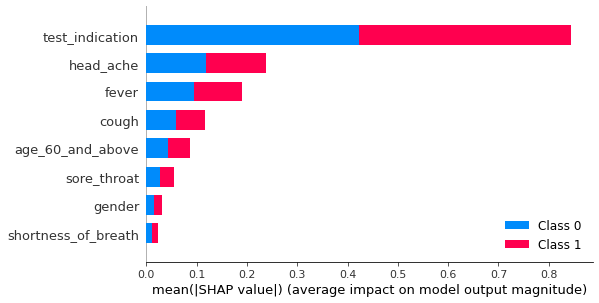

In [38]:
shap.summary_plot(shap_values, X_test, plot_type = 'bar')

# Correlation Matrix